# Volná pád a terminální rychlost

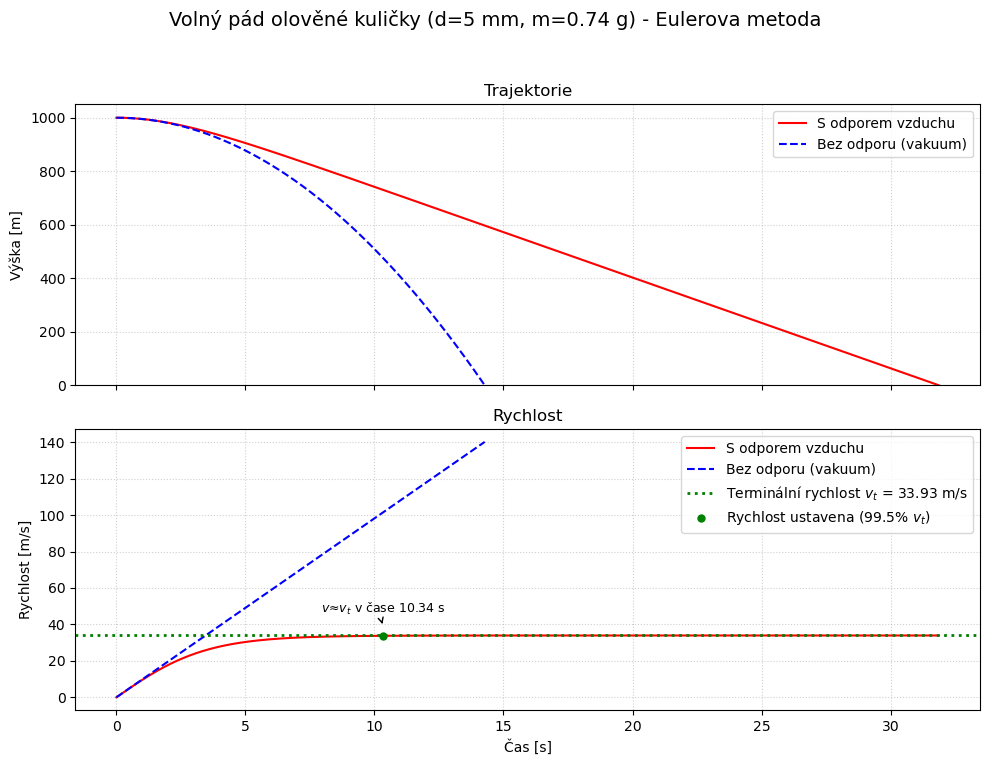

Terminální rychlost (analyticky): 33.93 m/s
Doba dopadu s odporem: 31.871 s
Doba dopadu ve vakuu: 14.272 s


In [84]:
import numpy as np
import matplotlib.pyplot as plt

# --- Fyzikální konstanty a počáteční podmínky ---
g = 9.82          # gravitační zrychlení (m/s^2)
rho = 1.29        # hustota vzduchu (kg/m^3)
Cd = 0.5          # součinitel odporu pro kouli (Newtonovský režim)
h0 = 1000         # počáteční výška (m)
v0 = 0            # počáteční rychlost (m/s)

# REALISTIČTĚJŠÍ PARAMETRY (opraveno z původních nereálných hodnot)
d = 0.005         # průměr padající koule (5 mm)
rho_bullet = 11340 # hustota padající koule (olovo) (kg/m^3)

# Odvozené parametry
S = np.pi * (d / 2)**2        # průřez padající koule
m = 4/3 * np.pi * (d / 2)**3 * rho_bullet # hmotnost padající koule

tmax = 80         # doba, po kterou simulaci sledujeme 
dt = 0.001        # časový krok pro numerický výpočet (Euler)

# --- Funkce pro odporovou sílu ---
def Fo(v, rho, Cd, S):
    """Odporová síla úměrná čtverci rychlosti (Newtonovský režim)"""
    return 0.5 * rho * Cd * S * v**2

# --- Hlavní simulační funkce ---
def solve_free_fall_euler(h0, v0, tmax, dt, g, m, rho, Cd, S, resistance_on=True):
    """
    Řeší volný pád s/bez odporu vzduchu pomocí explicitní Eulerovy metody.
    
    Vrací pole času, výšky a rychlosti až do dopadu (y <= 0).
    """
    t = np.arange(0, tmax, dt)
    n = np.size(t)
    v = np.empty(n)
    a = np.empty(n)
    y = np.empty(n)
    
    # Počáteční podmínky
    v[0] = v0
    y[0] = h0
    
    # Počáteční zrychlení
    F_drag_0 = Fo(v0, rho, Cd, S) if resistance_on else 0
    a[0] = g - F_drag_0 / m

    imax = n
    istop = False
    
    for i in range(1, n):
        # 1. Výpočet nové výšky (Eulerova metoda pro y)
        y[i] = y[i-1] - v[i-1] * dt
        
        # Kontrola dopadu na zem
        if y[i] <= 0:
            y[i] = 0 # Nastavíme přesně na nulu
            imax = i + 1
            istop = True
        
        # 2. Výpočet nové rychlosti (Eulerova metoda pro v)
        v[i] = v[i-1] + a[i-1] * dt
        
        # 3. Výpočet nového zrychlení (pro další krok)
        if resistance_on:
            F_drag_i = Fo(v[i], rho, Cd, S)
            a[i] = g - F_drag_i / m
        else:
            a[i] = g # Bez odporu je zrychlení konstantní
            
        if istop:
            break
            
    # Oříznutí polí na dobu do dopadu
    return t[:imax], y[:imax], v[:imax], a[:imax]

# --- Spuštění simulací ---

# 1. Simulace s odporem
t_res, y_res, v_res, a_res = solve_free_fall_euler(
    h0, v0, tmax, dt, g, m, rho, Cd, S, resistance_on=True
)

# 2. Simulace bez odporu (Volný pád ve vakuu)
t_no_res, y_no_res, v_no_res, a_no_res = solve_free_fall_euler(
    h0, v0, tmax, dt, g, m, rho, Cd, S, resistance_on=False
)

# --- Výpočet mezní (terminální) rychlosti ---
v_terminal = np.sqrt((2 * m * g) / (rho * Cd * S))

# --- Vykreslení výsledků ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.suptitle(f'Volný pád olověné kuličky (d={d*1000:.0f} mm, m={m*1000:.2f} g) - Eulerova metoda', fontsize=14)

# 1. GRAF: Výška vs. Čas
ax1.plot(t_res, y_res, label='S odporem vzduchu', color='red')
ax1.plot(t_no_res, y_no_res, label='Bez odporu (vakuum)', color='blue', linestyle='--')
ax1.set_ylabel('Výška [m]')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend()
ax1.set_title('Trajektorie')
ax1.set_ylim(bottom=0)

# 2. GRAF: Rychlost vs. Čas
ax2.plot(t_res, v_res, label='S odporem vzduchu', color='red')
ax2.plot(t_no_res, v_no_res, label='Bez odporu (vakuum)', color='blue', linestyle='--')

# Vyznačení terminální rychlosti
ax2.axhline(v_terminal, color='green', linestyle=':', linewidth=2, label=f'Terminální rychlost $v_t$ = {v_terminal:.2f} m/s')

# Vyznačení bodu, kdy zrychlení kleslo blízko nuly (rychlost se přestává zvyšovat)
# Najdeme index, kde se rychlost blíží v_terminal (např. 99.5% v_t)
try:
    idx_vt = np.where(v_res >= v_terminal * 0.995)[0][0]
    ax2.plot(t_res[idx_vt], v_res[idx_vt], 'o', color='green', markersize=5, label='Rychlost ustavena (99.5% $v_t$)')
    ax2.annotate(
        f'$v \u2248 v_t$ v čase {t_res[idx_vt]:.2f} s', 
        (t_res[idx_vt], v_res[idx_vt] + 5), 
        textcoords="offset points", 
        xytext=(0,10), 
        ha='center', 
        fontsize=9, 
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2")
    )
except IndexError:
    pass # Kulička nedosáhla 99.5% v_t

ax2.set_xlabel('Čas [s]')
ax2.set_ylabel('Rychlost [m/s]')
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend()
ax2.set_title('Rychlost')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Upraví rozložení pro suptitle
plt.show()

print(f"Terminální rychlost (analyticky): {v_terminal:.2f} m/s")
print(f"Doba dopadu s odporem: {t_res[-1]:.3f} s")
print(f"Doba dopadu ve vakuu: {t_no_res[-1]:.3f} s")